In [251]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kruskal, pointbiserialr
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 3)

warnings.filterwarnings('ignore')



In [252]:
#loading the dataset

df_trustpilot = pd.read_csv('data/data_trustpilot_3.csv', engine='python')
train_df = pd.read_csv('data/train_trustpilot_3.csv', engine='python')
test_df = pd.read_csv('data/test_trustpilot_3.csv', engine='python')

# Load TF-IDF matrices
X_train_tfidf = np.load('data/X_train_tfidf.npy')
X_test_tfidf = np.load('data/X_test_tfidf.npy')
tfidf_features = np.load('data/tfidf_features.npy', allow_pickle=True)

# Load BoW matrices
X_train_bow = np.load('data/X_train_bow.npy')
X_test_bow = np.load('data/X_test_bow.npy')
bow_features = np.load('data/bow_features.npy', allow_pickle=True)


print("Dataset shapes:")
print(f"Full dataset: {df_trustpilot.shape}")
print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

print("Text feature matrices shapes:")
print(f"TF-IDF training: {X_train_tfidf.shape}")
print(f"TF-IDF testing: {X_test_tfidf.shape}")
print(f"BoW training: {X_train_bow.shape}")
print(f"BoW testing: {X_test_bow.shape}")

display(train_df.head())



Dataset shapes:
Full dataset: (64170, 34)
Training set: (51336, 34)
Test set: (12834, 34)
Text feature matrices shapes:
TF-IDF training: (51336, 5000)
TF-IDF testing: (12834, 5000)
BoW training: (51336, 5000)
BoW testing: (12834, 5000)


,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded
0,2,US,B Shivers,1,Verified,one-time,0,Quicken,Since about April 2nd I have to launch Quicken twice as it often will close itself after the first time.I also can't get it to memorize an account password for One step updating.,since april 2nd launch quicken twice often close first timei also cant get memorize account password one step updating,118,19,0.125,3.0,0.000,3,Have to launch Quicken twice,launch quicken twice,20.0,3.0,0,0,0,2024-04-11,2024-04-11 14:50:48,2024-04-11,4,7,Morning,3,Business Day,0,quick_review,1
1,1,GB,Wolfe,3,Not Verified,repeat,1,Asda,"Waiting for over 1 minute for someone to verify age at self scan till. The assistants were more interested in there conversation then verify my age. Then only came over when I DEMANDED they do their job.Then at the kiosk they refused to pay out my £10 scratchcard win. So I had to drive to a shop 3 miles away to cash it.This store is a joke. TERRIBLE CUSTOMER SERVICE, POORLY TRAINED AND UNHELPFUL STAFF.",waiting 1 minute someone verify age self scan till assistants interested conversation verify age came demanded jobthen kiosk refused pay 10 scratchcard win drive shop 3 miles away cash itthis store joke terrible customer service poorly trained unhelpful staff,259,39,-0.087,3.0,0.273,4,"ASDA CHATHAM ""TERRIBLE CUSTOMER SERVICE""",asda chatham terrible customer service,38.0,5.0,0,0,0,2021-01-23,2021-01-23 09:42:58,2021-01-23,1,8,Morning,5,Weekend,0,quick_review,1
2,5,US,Brian,2,Verified,repeat,1,Quicken,"I use to keep track of our finances . Download 2-3 times a week. Twice over the years , I have seen unauthorized charges and was able to take care of quickly, both times ,someone had stolen my identity on a card. It's great for tax time and running updates on spending and liquid net worth",use keep track finances download 23 times week twice years seen unauthorized charges able take care quickly times someone stolen identity card great tax time running updates spending liquid net worth,199,31,0.387,4.0,0.599,4,I use to keep track of our finances,use keep track finances,23.0,4.0,0,0,0,2024-05-26,2024-05-27 16:06:29,2024-05-27,5,9,Business Hours,0,Business Day,0,late_review,0
3,5,US,Customer,2,Verified,repeat,1,Flashbay,Service was great by Jamie Emery. Very helpful. Product ideas were strong and nice selection in each class to choose from. A bit higher end than most and super fast delivery from order to receipt. Well done.,service great jamie emery helpful product ideas strong nice selection class choose bit higher end super fast delivery order receipt well done,141,22,0.436,4.0,0.958,5,Service was great by Jamie Emery,service great jamie emery,25.0,4.0,"Hello, This is what we love to hear!It’s great to hear that Jamie was able to answer all of your questions, and you are happy with the final product.We appreciate your business!-Flashbay Management",hello love hearits great hear jamie able answer questions happy final productwe appreciate businessflashbay management,1,2019-04-23,2019-04-23 13:08:14,2019-04-23,4,6,Morning,1,Business Day,0,quick_review,1
4,1,GB,Keith,6,Not Verified,repeat,1,Asda,"The car park is disgraceful with people allowed to park in the mother and baby bays clearly without children,and disabled bays with people who don’t have blue badges,staff will not do anything as it’s (not my job) !!!!",car park disgraceful people allowed park mother baby bays clearly without childrenand disabled bays people dont blue badgesstaff anything job,141,20,-0.033,3.0,0.402,4,The car park

In [253]:
#First check
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])
df_trustpilot['date_of_experience'] = pd.to_datetime(df_trustpilot['date_of_experience'])
df_trustpilot['date_posted'] = pd.to_datetime(df_trustpilot['date_posted'])
print(df_trustpilot.columns)
display(df_trustpilot.info())

train_df['local_date_posted'] = pd.to_datetime(train_df['local_date_posted'])
train_df['date_of_experience'] = pd.to_datetime(train_df['date_of_experience'])
train_df['date_posted'] = pd.to_datetime(train_df['date_posted'])
print(train_df.columns)
display(train_df.info())

test_df['local_date_posted'] = pd.to_datetime(test_df['local_date_posted'])
test_df['date_of_experience'] = pd.to_datetime(test_df['date_of_experience'])
test_df['date_posted'] = pd.to_datetime(test_df['date_posted'])
print(test_df.columns)
display(test_df.info())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64170 entries, 0 to 64169
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64170 non-null  in

None

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            51336 non-null  in

None

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12834 entries, 0 to 12833
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            12834 non-null  in

None

STAGE 1 - HEATMAP 

In [254]:
# Split features by type
binary_variables = ['repeat_reviewer', 'repeat_reviewer_encoded', 'answered_encoded', 'day_type', 'review_time', 'review_time_encoded']
categorical_text = ['location', 'username', 'verification', 'company', 'text', 'text_processed', 'subject', 'subject_processed', 'answer', 'answer_processed', 'time_of_day']
categorical_ordinal = ['rating', 'Sentiment_Blob_cat',  'Sentiment_VADER_cat']
true_numeric = ['number_reviews', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_VADER', 'subject_length', 'subject_word_length', 'days_between_experience_and_post']
time_based_numeric = ['month_local', 'local_hour',  'day_of_week_posted']
datetime_columns = ['date_of_experience', 'date_posted', 'local_date_posted']

# Create DataFrame with numeric and ordinal features for correlation analysis
numeric_for_correlation = train_df[true_numeric + categorical_ordinal + time_based_numeric].copy()

# Create DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(X_train_tfidf, columns=[f'tfidf_{i}' for i in range(X_train_tfidf.shape[1])])
top_n_tfidf = 15
top_tfidf_cols = tfidf_df.apply(lambda x: abs(x.corr(train_df['rating']))).nlargest(top_n_tfidf).index

# Create DataFrame with BoW features
bow_df = pd.DataFrame(X_train_bow, columns=[f'bow_{i}' for i in range(X_train_bow.shape[1])])
top_n_bow = 15
top_bow_cols = bow_df.apply(lambda x: abs(x.corr(train_df['rating']))).nlargest(top_n_bow).index



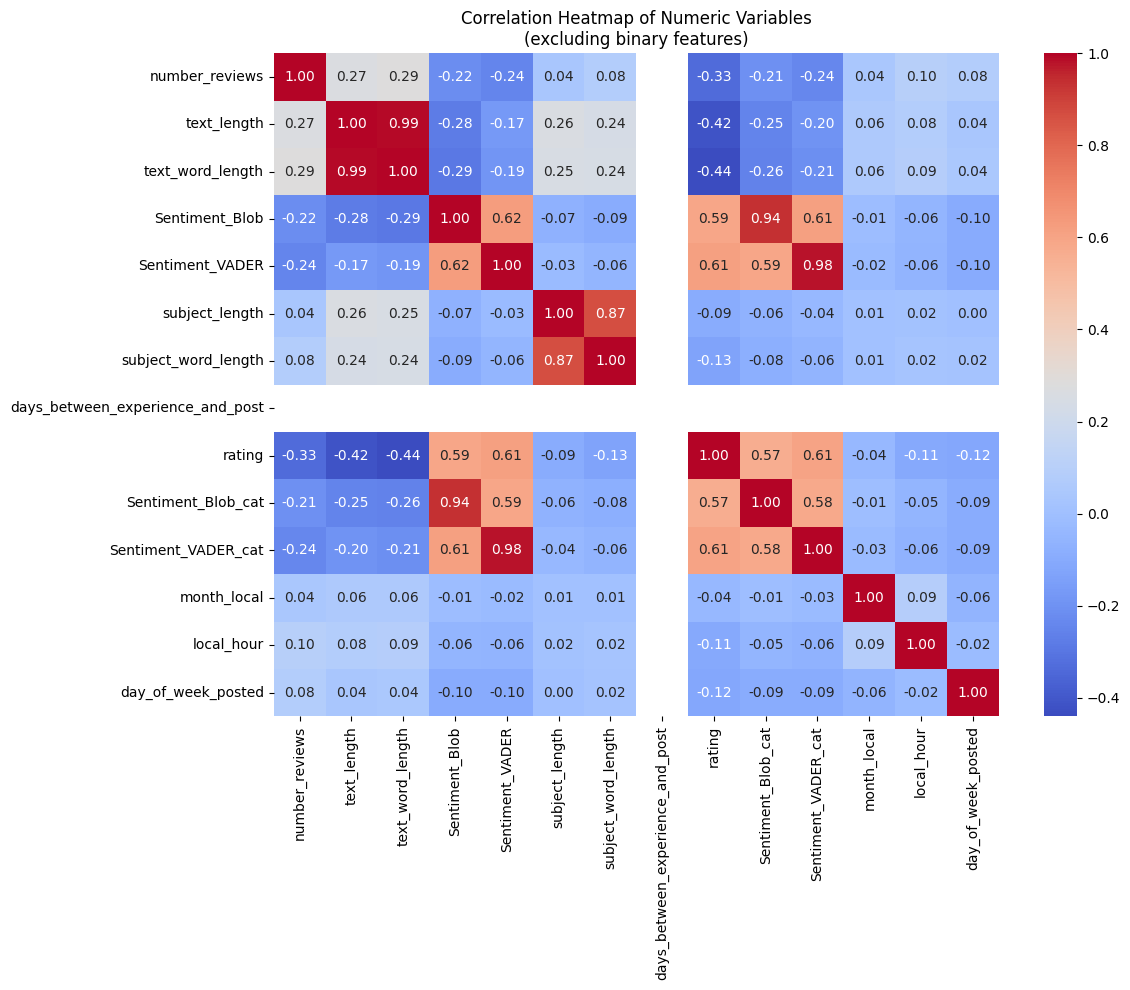

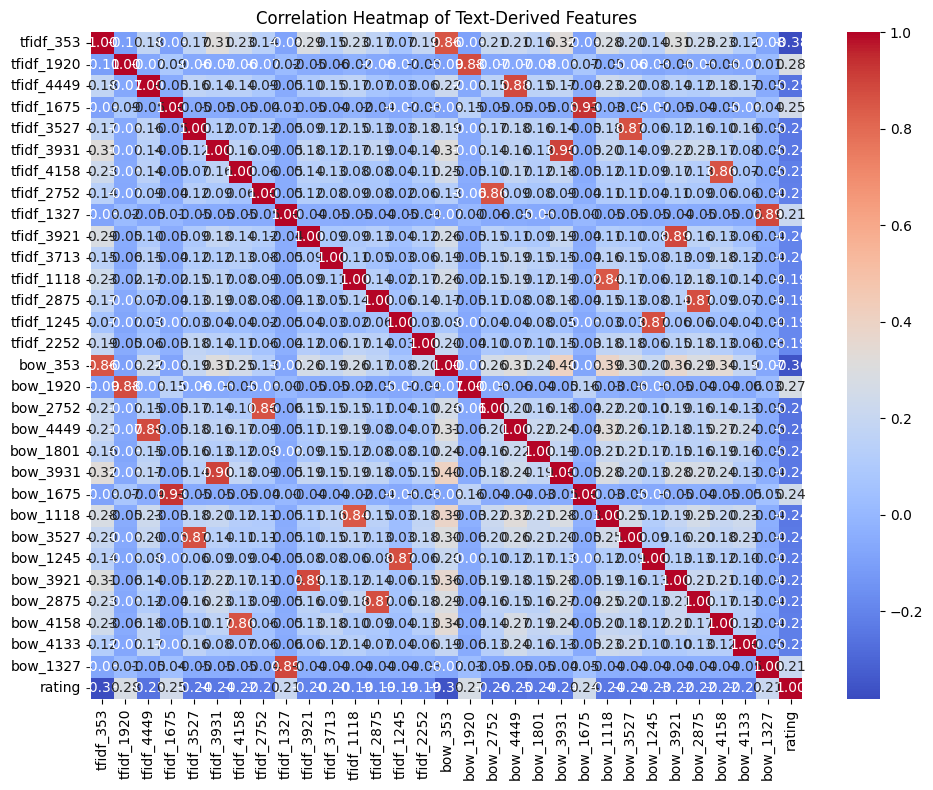

Highly correlated pairs (>0.7) with analysis:
Original Numeric Variables:
text_word_length & text_length: 0.994
Correlation with rating: text_word_length: 0.440, text_length: 0.416
Recommendation: Keep text_word_length (stronger correlation with target)
subject_word_length & subject_length: 0.869
Correlation with rating: subject_word_length: 0.135, subject_length: 0.092
Recommendation: Keep subject_word_length (stronger correlation with target)
Sentiment_Blob_cat & Sentiment_Blob: 0.937
Correlation with rating: Sentiment_Blob_cat: 0.567, Sentiment_Blob: 0.594
Recommendation: Keep Sentiment_Blob (stronger correlation with target)
Sentiment_VADER_cat & Sentiment_VADER: 0.982
Correlation with rating: Sentiment_VADER_cat: 0.605, Sentiment_VADER: 0.613
Recommendation: Keep Sentiment_VADER (stronger correlation with target)
Text-Derived Features:
bow_353 & tfidf_353: 0.858
Correlation with rating: bow_353: 0.360, tfidf_353: 0.382
Recommendation: Keep tfidf_353 (stronger correlation with targ

In [255]:
# Correlation heatmaps
# 1. True numeric and ordinal variables
original_corr = numeric_for_correlation.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(original_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables\n(excluding binary features)')
plt.tight_layout()
plt.show()

# 2. Text-derived features
text_features_with_rating = pd.concat([tfidf_df[top_tfidf_cols], bow_df[top_bow_cols], train_df['rating']], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(text_features_with_rating, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Text-Derived Features')
plt.tight_layout()
plt.show()

# Analyze correlations and print results
print("Highly correlated pairs (>0.7) with analysis:")
print("Original Numeric Variables:")
for i in range(len(original_corr.columns)):
    for j in range(i):
        if abs(original_corr.iloc[i, j]) > 0.7:
            var1 = original_corr.columns[i]
            var2 = original_corr.columns[j]
            correlation = original_corr.iloc[i, j]
            corr_with_target1 = abs(original_corr.loc[var1, 'rating'])
            corr_with_target2 = abs(original_corr.loc[var2, 'rating'])
            print(f"{var1} & {var2}: {correlation:.3f}")
            print(f"Correlation with rating: {var1}: {corr_with_target1:.3f}, "
                  f"{var2}: {corr_with_target2:.3f}")
            print(f"Recommendation: Keep {var1 if corr_with_target1 > corr_with_target2 else var2} "
                  f"(stronger correlation with target)")

print("Text-Derived Features:")
for i in range(len(text_features_with_rating.columns)):
    for j in range(i):
        if abs(text_features_with_rating.iloc[i, j]) > 0.7:
            var1 = text_features_with_rating.columns[i]
            var2 = text_features_with_rating.columns[j]
            if var1 != 'rating' and var2 != 'rating':
                correlation = text_features_with_rating.iloc[i, j]
                corr_with_target1 = abs(text_features_with_rating.loc[var1, 'rating'])
                corr_with_target2 = abs(text_features_with_rating.loc[var2, 'rating'])
                print(f"{var1} & {var2}: {correlation:.3f}")
                print(f"Correlation with rating: {var1}: {corr_with_target1:.3f}, "
                      f"{var2}: {corr_with_target2:.3f}")
                print(f"Recommendation: Keep {var1 if corr_with_target1 > corr_with_target2 else var2} "
                      f"(stronger correlation with target)")

print("\nNote: Binary variables were excluded from correlation analysis as they require "
      "different statistical approaches (e.g., point-biserial correlation).")

In [256]:
# Point-biserial correlation with binary features and'rating'
for binary_var in ['repeat_reviewer_encoded', 'answered_encoded', 'review_time_encoded']:
    corr, p_value = pointbiserialr(train_df[binary_var], train_df['rating'])
    print(f"{binary_var}: Point-biserial correlation with 'rating' = {corr:.3f} (p-value = {p_value:.3e})")


repeat_reviewer_encoded: Point-biserial correlation with 'rating' = -0.249 (p-value = 0.000e+00)
answered_encoded: Point-biserial correlation with 'rating' = 0.395 (p-value = 0.000e+00)
review_time_encoded: Point-biserial correlation with 'rating' = 0.129 (p-value = 2.719e-188)


STAGE 2 - ENCODING

In [257]:
#Encoding

def encode_features(train_df, test_df):
    # 1. Ordinal Encoding
    # time_of_day encoding
    time_of_day_order = ['Morning', 'Business Hours', 'Evening', 'Night']
    train_df['time_of_day_encoded'] = pd.Categorical(
        train_df['time_of_day'], 
        categories=time_of_day_order).codes
    test_df['time_of_day_encoded'] = pd.Categorical(
        test_df['time_of_day'], 
        categories=time_of_day_order).codes
    
    # verification encoding
    verification_order = ['Verified', 'Invited', 'Redirected', 'Not Verified']
    train_df['verification_encoded'] = pd.Categorical(
        train_df['verification'], 
        categories=verification_order).codes
    test_df['verification_encoded'] = pd.Categorical(
        test_df['verification'], 
        categories=verification_order).codes
    
    # 2. Label Encoding for location
    all_locations = pd.concat([train_df['location'], test_df['location']]).unique()
    location_map = {loc: idx for idx, loc in enumerate(sorted(all_locations))}
    
    train_df['location_encoded'] = train_df['location'].map(location_map)
    test_df['location_encoded'] = test_df['location'].map(location_map)
    
    # 3. One-Hot Encoding
    for column in ['company', 'day_type']:
        all_values = pd.concat([train_df[column], test_df[column]]).unique()
        
        dummy_cols = pd.get_dummies(train_df[column], prefix=column, dtype=int)
        train_df = pd.concat([train_df, dummy_cols], axis=1)
        
        dummy_cols_test = pd.get_dummies(test_df[column], prefix=column, dtype=int)
        
        for val in all_values:
            col_name = f"{column}_{val}"
            if col_name not in dummy_cols.columns:
                train_df[col_name] = 0
            if col_name not in dummy_cols_test.columns:
                test_df[col_name] = 0
    
    return train_df, test_df

train_df, test_df = encode_features(train_df, test_df)

STAGE 3 - SCALE/NORMALIZE/STANDARDIZE

In [258]:
#Scaling and normalization

def scale_features(train_df, test_df):
   standardize_columns = [
       'text_length', 'subject_length',
       'text_word_length', 'subject_word_length',
       'days_between_experience_and_post',
       'number_reviews']
   
   normalize_columns = [
       'location_encoded',
       'verification_encoded',
       'time_of_day_encoded']
   
   std_scaler = StandardScaler()
   minmax_scaler = MinMaxScaler()
   
   if standardize_columns:
       train_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.fit_transform(
           train_df[standardize_columns])
       test_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.transform(
           test_df[standardize_columns])
   
   if normalize_columns:
       train_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.fit_transform(
           train_df[normalize_columns])
       test_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.transform(
           test_df[normalize_columns])
   
   return train_df, test_df, {'standard': std_scaler, 'minmax': minmax_scaler}

train_df, test_df, scalers = scale_features(train_df, test_df)

print("Training set statistics after scaling:")
print("Standardized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_scaled')]].describe())
print("Normalized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_normalized')]].describe())

Training set statistics after scaling:
Standardized features:
       text_length_scaled  subject_length_scaled  text_word_length_scaled  subject_word_length_scaled  days_between_experience_and_post_scaled  number_reviews_scaled
count           5.134e+04              5.134e+04                5.134e+04                   5.134e+04                                  51336.0              5.134e+04
mean            6.042e-17             -1.258e-16                2.062e-17                  -1.610e-16                                      0.0              8.997e-18
std             1.000e+00              1.000e+00                1.000e+00                   1.000e+00                                      0.0              1.000e+00
min            -1.249e+00             -2.374e+00               -1.208e+00                  -1.701e+00                                      0.0             -6.740e-01
25%            -7.724e-01             -6.953e-01               -7.869e-01                  -3.527e-01       

In [259]:
display(train_df.head())
print(train_df.info())

,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded,time_of_day_encoded,verification_encoded,location_encoded,company_Asda,company_Flashbay,company_Quicken,company_SteelSeries,day_type_Business Day,day_type_Weekend,text_length_scaled,subject_length_scaled,text_word_length_scaled,subject_word_length_scaled,days_between_experience_and_post_scaled,number_reviews_scaled,location_encoded_normalized,verification_encoded_normalized,time_of_day_encoded_normalized
0,2,US,B Shivers,1,Verified,one-time,0,Quicken,Since about April 2nd I have to launch Quicken twice as it often will close itself after the first time.I also can't get it to memorize an account password for One step updating.,since april 2nd launch quicken twice often close first timei also cant get memorize account password one step updating,118,19,0.125,3.0,0.000,3,Have to launch Quicken twice,launch quicken twice,20.0,3.0,0,0,0,2024-04-11,2024-04-11 14:50:48,2024-04-11,4,7,Morning,3,Business Day,0,quick_review,1,0,0,135,0,0,1,0,1,0,-0.373,-0.360,-0.261,-0.353,0.0,-0.674,0.944,0.0,0.000
1,1,GB,Wolfe,3,Not Verified,repeat,1,Asda,"Waiting for over 1 minute for someone to verify age at self scan till. The assistants were more interested in there conversation then verify my age. Then only came over when I DEMANDED they do their job.Then at the kiosk they refused to pay out my £10 scratchcard win. So I had to drive to a shop 3 miles away to cash it.This store is a joke. TERRIBLE CUSTOMER SERVICE, POORLY TRAINED AND UNHELPFUL STAFF.",waiting 1 minute someone verify age self scan till assistants interested conversation verify age came demanded jobthen kiosk refused pay 10 scratchcard win drive shop 3 miles away cash itthis store joke terrible customer service poorly trained unhelpful staff,259,39,-0.087,3.0,0.273,4,"ASDA CHATHAM ""TERRIBLE CUSTOMER SERVICE""",asda chatham terrible customer service,38.0,5.0,0,0,0,2021-01-23,2021-01-23 09:42:58,2021-01-23,1,8,Morning,5,Weekend,0,quick_review,1,0,3,52,1,0,0,0,0,1,0.712,1.654,0.790,1.444,0.0,0.495,0.364,1.0,0.000
2,5,US,Brian,2,Verified,repeat,1,Quicken,"I use to keep track of our finances . Download 2-3 times a week. Twice over the years , I have seen unauthorized charges and was able to take care of quickly, both times ,someone had stolen my identity on a card. It's great for tax time and running updates on spending and liquid net worth",use keep track finances download 23 times week twice years seen unauthorized charges able take care quickly times someone stolen identity card great tax time running updates spending liquid net worth,199,31,0.387,4.0,0.599,4,I use to keep track of our finances,use keep track finances,23.0,4.0,0,0,0,2024-05-26,2024-05-27 16:06:29,2024-05-27,5,9,Business Hours,0,Business Day,0,late_review,0,1,0,135,0,0,1,0,1,0,0.250,-0.024,0.370,0.546,0.0,-0.090,0.944,0.0,0.333
3,5,US,Customer,2,Verified,repeat,1,Flashbay,Service was great by Jamie Emery. Very helpful. Product ideas were strong and nice selection in each class to choose from. A bit higher end than most and super fast delivery from order to receipt. Well done.,service great jamie emery helpful product ideas strong nice selection class choose bit higher end super fast delivery order receipt well done,141,22,0.436,4.0,0.958,5,Service was great by Jamie Emery,service great jamie emery,25.0,4.0,"Hello, This is what we love to hear!It’s great to hear that Jamie was able to answer all of your questions, and you are happy with the final product.We appreciate your business!-Flashbay Management",hello love hearits great h

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 52 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   rating                                   51336 non-null  int64         
 1   location                                 51336 non-null  object        
 2   username                                 51336 non-null  object        
 3   number_reviews                           51336 non-null  int64         
 4   verification                             51336 non-null  object        
 5   repeat_reviewer                          51336 non-null  object        
 6   repeat_reviewer_encoded                  51336 non-null  int64         
 7   company                                  51336 non-null  object        
 8   text                                     51336 non-null  object        
 9   text_processed                         

In [260]:
#Split variables by type
#Cannot be used in statistical tests
text_content = ['text', 'text_processed', 'subject', 'subject_processed', 'answer', 'answer_processed', 'username']
raw_categorical = ['day_type', 'review_time', 'repeat_reviewer', 'company', 'location',  'verification', 'time_of_day', 'date_of_experience', 'date_posted', 'local_date_posted']

#Can be used in statistical tests
binary_variables = ['repeat_reviewer_encoded', 'answered_encoded', 'review_time_encoded',  'company_Asda', 'company_Flashbay', 'company_SteelSeries', 'company_Quicken', 'day_type_Business Day', 'day_type_Weekend']
categorical_ordinal = ['Sentiment_Blob_cat',  'Sentiment_VADER_cat', 'time_of_day_encoded', 'verification_encoded']
categorical_nominal = ['location_encoded']
true_numeric = ['number_reviews', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_VADER', 'subject_length', 'subject_word_length', 'days_between_experience_and_post', 'text_length_scaled', 'subject_length_scaled', 'text_word_length_scaled', 'subject_word_length_scaled', 'days_between_experience_and_post_scaled', 'number_reviews_scaled', 'location_encoded_normalized', 'verification_encoded_normalized', 'time_of_day_encoded_normalized']
time_based_numeric = ['month_local', 'local_hour',  'day_of_week_posted']

full_set = binary_variables + categorical_nominal + categorical_ordinal + text_content + true_numeric + time_based_numeric + raw_categorical
print(len(full_set))

statistical_features = binary_variables + categorical_ordinal + categorical_nominal + true_numeric + time_based_numeric

51


STAGE 4 - VARIANCE THRESHOLD

In [261]:
def calculate_variance_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    v_threshold = VarianceThreshold(threshold = 0.001)
    v_threshold.fit(train_df[statistical_features])
    regular_variances = dict(zip(statistical_features, [float(x) for x in v_threshold.variances_]))
    
    v_threshold.fit(X_train_tfidf)
    tfidf_variances = dict(zip(top_tfidf_cols, [float(x) for x in v_threshold.variances_]))
    
    v_threshold.fit(X_train_bow)
    bow_variances = dict(zip(top_bow_cols, [float(x) for x in v_threshold.variances_]))
    
    return {**regular_variances, **tfidf_variances, **bow_variances}

variance_scores = calculate_variance_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


STAGE 5 - MEAN ABSOLUTE DIFFERENCE

In [262]:
#Mean Absolute Difference
def calculate_mad_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    regular_mad = dict(zip(statistical_features, 
                          [float(np.sum(np.abs(train_df[feature] - np.mean(train_df[feature]))) / len(train_df)) 
                           for feature in statistical_features]))
    tfidf_mad = dict(zip(top_tfidf_cols,
                        [float(np.sum(np.abs(X_train_tfidf[:, i] - np.mean(X_train_tfidf[:, i]))) / len(X_train_tfidf))
                         for i in range(len(top_tfidf_cols))]))
    bow_mad = dict(zip(top_bow_cols,
                      [float(np.sum(np.abs(X_train_bow[:, i] - np.mean(X_train_bow[:, i]))) / len(X_train_bow))
                       for i in range(len(top_bow_cols))]))
    
    all_mad = {**regular_mad, **tfidf_mad, **bow_mad}
    return all_mad

mad_scores = calculate_mad_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


STAGE 6 - PEARSON AND SPEARMAN

In [263]:
#Pearson and Spearman
def calculate_correlation_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    correlations = {}
    for feature in statistical_features:
        pearson_coef, pearson_p = pearsonr(train_df['rating'], train_df[feature])
        spearman_coef, spearman_p = spearmanr(train_df['rating'], train_df[feature])
        correlations[feature] = {
            'pearson_coef': float(pearson_coef),
            'pearson_p': float(pearson_p),
            'spearman_coef': float(spearman_coef),
            'spearman_p': float(spearman_p)}
    for i, feature in enumerate(top_tfidf_cols):
        pearson_coef, pearson_p = pearsonr(train_df['rating'], X_train_tfidf[:, i])
        spearman_coef, spearman_p = spearmanr(train_df['rating'], X_train_tfidf[:, i])
        correlations[feature] = {
            'pearson_coef': float(pearson_coef),
            'pearson_p': float(pearson_p),
            'spearman_coef': float(spearman_coef),
            'spearman_p': float(spearman_p)}
    for i, feature in enumerate(top_bow_cols):
        pearson_coef, pearson_p = pearsonr(train_df['rating'], X_train_bow[:, i])
        spearman_coef, spearman_p = spearmanr(train_df['rating'], X_train_bow[:, i])
        correlations[feature] = {
            'pearson_coef': float(pearson_coef),
            'pearson_p': float(pearson_p),
            'spearman_coef': float(spearman_coef),
            'spearman_p': float(spearman_p)}
    
    return correlations

correlation_scores = calculate_correlation_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


STAGE 7 - ANOVA

In [264]:
#Anova

def calculate_anova_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):

    anova_results = {}
    
    for feature in statistical_features:
        df_temp = pd.DataFrame({
            'feature_value': train_df[feature],
            'rating': train_df['rating']})
        result = smf.ols('feature_value ~ rating', data=df_temp).fit()
        table = sm.stats.anova_lm(result)
        anova_results[feature] = {
            'f_stat': float(table['F'][0]),
            'p_value': float(table['PR(>F)'][0])}
    
    for i, feature in enumerate(top_tfidf_cols):
        df_temp = pd.DataFrame({
            'feature_value': X_train_tfidf[:, i],
            'rating': train_df['rating']})
        result = smf.ols('feature_value ~ rating', data=df_temp).fit()
        table = sm.stats.anova_lm(result)
        anova_results[feature] = {
            'f_stat': float(table['F'][0]),
            'p_value': float(table['PR(>F)'][0])}
    
    for i, feature in enumerate(top_bow_cols):
        df_temp = pd.DataFrame({
            'feature_value': X_train_bow[:, i],
            'rating': train_df['rating']})
        result = smf.ols('feature_value ~ rating', data=df_temp).fit()
        table = sm.stats.anova_lm(result)
        anova_results[feature] = {
            'f_stat': float(table['F'][0]),
            'p_value': float(table['PR(>F)'][0])}
    
    return anova_results

anova_scores = calculate_anova_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


STAGE 8 - MUTUAL INFORMATION

In [265]:
# Mutual Information
tfidf_features = X_train_tfidf[:, :len(top_tfidf_cols)]
bow_features = X_train_bow[:, :len(top_bow_cols)]

X = np.hstack([
    train_df[statistical_features].values,
    X_train_tfidf[:, :len(top_tfidf_cols)],
    X_train_bow[:, :len(top_bow_cols)]])

all_columns = (statistical_features + 
              list(top_tfidf_cols) + 
              list(top_bow_cols))

importances = mutual_info_classif(X, train_df['rating'])
feat_importances = pd.Series(importances, index=all_columns)
mi_scores = {k: float(v) for k, v in feat_importances.to_dict().items()}


STAGE 9 - KRUSKAL-WALLIS TEST

In [266]:
#Kruskal-Wallis Test

def calculate_kruskal_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    kruskal_scores = {}  
    
    for feature in statistical_features:
        if feature in train_df.columns:
            groups = [train_df[feature][train_df['rating'] == level] 
                     for level in train_df['rating'].unique()]
            try:
                statistic, p_value = kruskal(*groups)
                kruskal_scores[feature] = {'statistic': float(statistic), 'p_value': float(p_value)}
                print(f"{feature}: statistic={statistic:.6f}, p-value={p_value:.6f}")
            except ValueError:
                continue

    # TF-IDF features
    if X_train_tfidf is not None:
        for i, feature in enumerate(top_tfidf_cols):
            groups = [X_train_tfidf[:, i][train_df['rating'] == level] 
                     for level in train_df['rating'].unique()]
            try:
                statistic, p_value = kruskal(*groups)
                kruskal_scores[feature] = {'statistic': float(statistic), 'p_value': float(p_value)}
                print(f"{feature}: statistic={statistic:.6f}, p-value={p_value:.6f}")
            except ValueError:
                continue

    if X_train_bow is not None:
        for i, feature in enumerate(top_bow_cols):
            groups = [X_train_bow[:, i][train_df['rating'] == level] 
                     for level in train_df['rating'].unique()]
            try:
                statistic, p_value = kruskal(*groups)
                kruskal_scores[feature] = {'statistic': float(statistic), 'p_value': float(p_value)}
                print(f"{feature}: statistic={statistic:.6f}, p-value={p_value:.6f}")
            except ValueError:
                continue
    
    return kruskal_scores

kruskal_scores = calculate_kruskal_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


repeat_reviewer_encoded: statistic=3372.473683, p-value=0.000000
answered_encoded: statistic=10876.051715, p-value=0.000000
review_time_encoded: statistic=2026.899193, p-value=0.000000
company_Asda: statistic=20298.166610, p-value=0.000000
company_Flashbay: statistic=14202.891419, p-value=0.000000
company_SteelSeries: statistic=506.748587, p-value=0.000000
company_Quicken: statistic=9516.847220, p-value=0.000000
day_type_Business Day: statistic=1231.763353, p-value=0.000000
day_type_Weekend: statistic=1231.763353, p-value=0.000000
Sentiment_Blob_cat: statistic=18532.499197, p-value=0.000000
Sentiment_VADER_cat: statistic=18173.664496, p-value=0.000000
time_of_day_encoded: statistic=711.111694, p-value=0.000000
verification_encoded: statistic=14624.319430, p-value=0.000000
location_encoded: statistic=11602.225771, p-value=0.000000
number_reviews: statistic=5015.409429, p-value=0.000000
text_length: statistic=7840.811142, p-value=0.000000
text_word_length: statistic=8702.423095, p-value=

STAGE 10 - RECURSIVE FEATURE ELIMINATION

In [267]:
#Recursive Feature Elimination

def analyze_recursive_feature_elimination(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    global rfe_ranks

    X = train_df[statistical_features].fillna(0)
    
    if isinstance(X_train_tfidf, np.ndarray):
        tfidf_df = pd.DataFrame(
            X_train_tfidf[:, :len(top_tfidf_cols)],
            columns=top_tfidf_cols)
        X = pd.concat([X, tfidf_df], axis=1)
        statistical_features.extend(top_tfidf_cols)
    if isinstance(X_train_bow, np.ndarray):
        bow_df = pd.DataFrame(
            X_train_bow[:, :len(top_bow_cols)],
            columns=top_bow_cols)
        X = pd.concat([X, bow_df], axis=1)
        statistical_features.extend(top_bow_cols)
    
    y = train_df['rating']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    estimator = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
    selector = RFE(estimator=estimator, n_features_to_select=10, step=1)
    selector.fit(X_scaled, y)
    
    rfe_ranks = dict(zip(X.columns, selector.ranking_))
    rfe_ranks = {k: int(v) for k, v in rfe_ranks.items()}  
    selected_features = X.columns[selector.support_].tolist()
    
    print(f"Number of features selected: {len(selected_features)}")
    print(f"Selected features: {', '.join(selected_features)}")
    
    ranked_features = {}
    for feature, rank in rfe_ranks.items():
        if rank not in ranked_features:
            ranked_features[rank] = []
        ranked_features[rank].append(feature)
    for rank in sorted(ranked_features.keys()):
        features = ranked_features[rank]
        status = "SELECTED" if rank == 1 else f"Eliminated (Round {rank-1})"
        print(f"Rank {rank} - {status}:")
        for feature in sorted(features):
            print(f" - {feature}")
    return {'selected_features': selected_features, 'ranked_features': ranked_features}

try:
    rfe_results = analyze_recursive_feature_elimination(
        train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)
except Exception as e:
    print(f"Error during analysis: {str(e)}")

Number of features selected: 10
Selected features: answered_encoded, company_Asda, company_Flashbay, company_Quicken, text_length, text_word_length, Sentiment_Blob, Sentiment_VADER, text_length_scaled, text_word_length_scaled
Rank 1 - SELECTED:
 - Sentiment_Blob
 - Sentiment_VADER
 - answered_encoded
 - company_Asda
 - company_Flashbay
 - company_Quicken
 - text_length
 - text_length_scaled
 - text_word_length
 - text_word_length_scaled
Rank 2 - Eliminated (Round 1):
 - company_SteelSeries
Rank 3 - Eliminated (Round 2):
 - Sentiment_VADER_cat
Rank 4 - Eliminated (Round 3):
 - verification_encoded_normalized
Rank 5 - Eliminated (Round 4):
 - number_reviews
Rank 6 - Eliminated (Round 5):
 - bow_1118
Rank 7 - Eliminated (Round 6):
 - bow_353
Rank 8 - Eliminated (Round 7):
 - bow_2875
Rank 9 - Eliminated (Round 8):
 - bow_1675
Rank 10 - Eliminated (Round 9):
 - bow_3921
Rank 11 - Eliminated (Round 10):
 - verification_encoded
Rank 12 - Eliminated (Round 11):
 - bow_4449
Rank 13 - Eliminate

STAGE 11 - LASSO

In [268]:
#Lasso

def analyze_lasso_feature_selection(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    global lasso_coef
    features_to_check = list(set(true_numeric + time_based_numeric + binary_variables + categorical_ordinal + categorical_nominal))
    
    X = train_df[features_to_check].fillna(0)
    
    if isinstance(X_train_tfidf, np.ndarray):
        tfidf_df = pd.DataFrame(
            X_train_tfidf[:, :len(top_tfidf_cols)],
            columns=top_tfidf_cols)
        X = pd.concat([X, tfidf_df], axis=1)
        features_to_check.extend(top_tfidf_cols)
    if isinstance(X_train_bow, np.ndarray):
        bow_df = pd.DataFrame(
            X_train_bow[:, :len(top_bow_cols)],
            columns=top_bow_cols)
        X = pd.concat([X, bow_df], axis=1)
        features_to_check.extend(top_bow_cols)
    
    y = train_df['rating']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
    lasso.fit(X_scaled, y)
    
    lasso_coef = dict(zip(X.columns, lasso.coef_))
    lasso_coef = {k: float(v) for k, v in lasso_coef.items()}  
    
    print(f"Best alpha: {lasso.alpha_:.6f}")
    
    for feature, coef in sorted(lasso_coef.items(), key=lambda x: abs(x[1]), reverse=True):
        importance = ("strong" if abs(coef) >= 0.5 else
            "moderate" if abs(coef) >= 0.1 else
            "weak" if abs(coef) >= 0.01 else
            "very weak" if abs(coef) > 0 else
            "eliminated")
        print(f"{feature}: {coef:.6f} ({importance})")
    return {'best_alpha': lasso.alpha_}

try:
    lasso_results = analyze_lasso_feature_selection(
        train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)
except Exception as e:
    print(f"Error during analysis: {str(e)}")

Best alpha: 0.001035
text_word_length: -0.732039 (strong)
text_length_scaled: 0.470167 (moderate)
Sentiment_VADER: 0.413542 (moderate)
company_Asda: -0.370276 (moderate)
company_Flashbay: 0.345585 (moderate)
Sentiment_Blob: 0.258801 (moderate)
Sentiment_Blob_cat: 0.103608 (moderate)
verification_encoded_normalized: -0.078037 (weak)
review_time_encoded: 0.055860 (weak)
company_SteelSeries: 0.048438 (weak)
number_reviews: 0.044966 (weak)
tfidf_3527: 0.044129 (weak)
repeat_reviewer_encoded: 0.044116 (weak)
text_word_length_scaled: -0.039467 (weak)
subject_length_scaled: -0.028862 (weak)
Sentiment_VADER_cat: 0.028645 (weak)
tfidf_1920: -0.023674 (weak)
answered_encoded: -0.023606 (weak)
bow_1118: 0.022663 (weak)
tfidf_2875: -0.013590 (weak)
bow_1801: -0.012930 (weak)
local_hour: -0.012349 (weak)
day_type_Weekend: -0.011439 (weak)
bow_1920: 0.010609 (weak)
month_local: -0.009435 (very weak)
tfidf_2752: 0.006553 (very weak)
bow_1245: -0.006230 (very weak)
tfidf_3921: -0.005446 (very weak)
tf

STAGE 12 - RANDOM FOREST IMPORTANCE

In [269]:
#Random Forest Importance

def analyze_random_forest_importance(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    global rf_importance
    
    features_to_check = list(set(true_numeric + time_based_numeric + binary_variables + categorical_ordinal + categorical_nominal))
    
    X = train_df[features_to_check].fillna(0)
    
    if isinstance(X_train_tfidf, np.ndarray):
        tfidf_df = pd.DataFrame(
            X_train_tfidf[:, :len(top_tfidf_cols)],
            columns=top_tfidf_cols)
        X = pd.concat([X, tfidf_df], axis=1)
        features_to_check.extend(top_tfidf_cols)
        
    if isinstance(X_train_bow, np.ndarray):
        bow_df = pd.DataFrame(
            X_train_bow[:, :len(top_bow_cols)],
            columns=top_bow_cols)
        X = pd.concat([X, bow_df], axis=1)
        features_to_check.extend(top_bow_cols)
    
    y = train_df['rating']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5,
                              min_samples_leaf=2, random_state=42)
    rf.fit(X_scaled, y)
    
    rf_importance = dict(zip(X.columns, rf.feature_importances_))
    rf_importance = {k: float(v) for k, v in rf_importance.items()}
    
    mean_importance = np.mean(list(rf_importance.values()))
    std_importance = np.std(list(rf_importance.values()))
    
    for feature, importance in sorted(rf_importance.items(), key=lambda x: x[1], reverse=True):
        if importance > mean_importance + std_importance:
            status = "Very Important"
        elif importance > mean_importance:
            status = "Important"
        elif importance < mean_importance - std_importance:
            status = "Consider Dropping"
        else:
            status = "Review"
        print(f"{feature}: {importance:.6f} ({status})")
    
    return {'mean_importance': float(mean_importance), 'std_importance': float(std_importance)}

try:
    rf_results = analyze_random_forest_importance(
        train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)
except Exception as e:
    print(f"Error during analysis: {str(e)}")

Sentiment_Blob: 0.142604 (Very Important)
Sentiment_VADER_cat: 0.089523 (Very Important)
Sentiment_Blob_cat: 0.081593 (Very Important)
company_Flashbay: 0.076882 (Very Important)
Sentiment_VADER: 0.073975 (Very Important)
verification_encoded: 0.069093 (Very Important)
verification_encoded_normalized: 0.068670 (Very Important)
company_Asda: 0.067613 (Very Important)
answered_encoded: 0.045457 (Very Important)
company_Quicken: 0.043705 (Important)
location_encoded: 0.035378 (Important)
location_encoded_normalized: 0.031540 (Important)
text_word_length_scaled: 0.028755 (Important)
text_length: 0.025882 (Important)
text_word_length: 0.022924 (Important)
text_length_scaled: 0.020301 (Important)
company_SteelSeries: 0.012712 (Review)
number_reviews: 0.008539 (Review)
review_time_encoded: 0.006987 (Review)
subject_length: 0.005791 (Review)
subject_length_scaled: 0.005433 (Review)
local_hour: 0.005199 (Review)
month_local: 0.005163 (Review)
number_reviews_scaled: 0.004502 (Review)
day_of_week

STAGE 13 - LOGISTIC REGRESSION WITH RIB RATIO STUDY

In [270]:
#Logistic Regression with RIB Ratio study

def calculate_rib_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    global rib_analysis
    rib_analysis = {}
    
    def analyze_feature(X, feature_name):
        try:
            y = (train_df['rating'] >= 4).astype(int)
            X = X.reshape(-1, 1)
            
            n_bins = 10 if len(np.unique(X)) > 2 else 2
            bins = np.percentile(X.ravel(), np.linspace(0, 100, n_bins))
            bin_indices = np.digitize(X.ravel(), bins)
            
            rib_ratios = []
            for i in range(1, len(bins) + 1):
                mask = bin_indices == i
                if sum(mask) > 0:
                    ratio = np.mean(y[mask]) / (1 - np.mean(y[mask]) + 1e-10)
                    rib_ratios.append(ratio)
            
            rib_stability = float(np.std(rib_ratios) / (np.mean(rib_ratios) + 1e-10))
            rib_range = float(max(rib_ratios) - min(rib_ratios))
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = LogisticRegression(random_state=42, max_iter=1000)
            model.fit(X_train, y_train)
            
            odds_ratio = float(np.exp(model.coef_[0][0]))
            auc_score = float(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
            
            correlation, p_value = stats.pointbiserialr(y, X.ravel())
            
            metrics = {'auc': auc_score,
                'rib_range': rib_range,
                'rib_stability': rib_stability,
                'p_value': float(p_value),
                'odds_ratio': odds_ratio,
                'correlation': float(correlation)}
            
            rib_analysis[feature_name] = metrics
            print(f"{feature_name}:")
            print(f"  AUC: {auc_score:.3f}")
            print(f"  RIB range: {rib_range:.3f}")
            print(f"  RIB stability: {rib_stability:.3f}")
            print(f"  Odds ratio: {odds_ratio:.3f}")
            print(f"  p-value: {p_value:.6f}")
            print(f"  Correlation: {correlation:.3f}\n")
            
        except Exception as e:
            print(f"Error analyzing {feature_name}: {str(e)}")
    
    for feature in statistical_features:
        if feature in train_df.columns:
            analyze_feature(train_df[feature].values, feature)
    
    if isinstance(X_train_tfidf, np.ndarray):
        for i, feature in enumerate(top_tfidf_cols):
            analyze_feature(X_train_tfidf[:, i], feature)
    
    if isinstance(X_train_bow, np.ndarray):
        for i, feature in enumerate(top_bow_cols):
            analyze_feature(X_train_bow[:, i], feature)
    
    return rib_analysis

rib_analysis = calculate_rib_scores(train_df, X_train_tfidf, X_train_bow, 
                                  top_tfidf_cols, top_bow_cols)

repeat_reviewer_encoded:
  AUC: 0.610
  RIB range: 1.262
  RIB stability: 0.420
  Odds ratio: 0.409
  p-value: 0.000000
  Correlation: -0.217

answered_encoded:
  AUC: 0.671
  RIB range: 9.643
  RIB stability: 0.840
  Odds ratio: 11.406
  p-value: 0.000000
  Correlation: 0.382

review_time_encoded:
  AUC: 0.558
  RIB range: 0.858
  RIB stability: 0.350
  Odds ratio: 2.082
  p-value: 0.000000
  Correlation: 0.147

company_Asda:
  AUC: 0.692
  RIB range: 2.202
  RIB stability: 0.903
  Odds ratio: 0.052
  p-value: 0.000000
  Correlation: -0.472

company_Flashbay:
  AUC: 0.697
  RIB range: 767.790
  RIB stability: 0.998
  Odds ratio: 526.397
  p-value: 0.000000
  Correlation: 0.451

company_SteelSeries:
  AUC: 0.534
  RIB range: 0.848
  RIB stability: 0.247
  Odds ratio: 1.672
  p-value: 0.000000
  Correlation: 0.094

company_Quicken:
  AUC: 0.540
  RIB range: 0.474
  RIB stability: 0.170
  Odds ratio: 0.707
  p-value: 0.000000
  Correlation: -0.083

day_type_Business Day:
  AUC: 0.553
  R

STAGE 14 - MULTICOLLINEARITY CHECK

In [271]:
def check_multicollinearity(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols, threshold=0.7):
    clean_features = [f for f in statistical_features if not (f.startswith('tfidf_') or f.startswith('bow_'))]
    X = train_df[clean_features].copy()
    if isinstance(X_train_tfidf, np.ndarray):
        X = pd.concat([X, pd.DataFrame(X_train_tfidf[:, :len(top_tfidf_cols)], columns=top_tfidf_cols)], axis=1)
    if isinstance(X_train_bow, np.ndarray):
        X = pd.concat([X, pd.DataFrame(X_train_bow[:, :len(top_bow_cols)], columns=top_bow_cols)], axis=1)
    corr_matrix = X.corr()
    
    def determine_feature_to_keep(feat1, feat2):
        if feat1 == feat2:
            return None, None, "Self-correlation"
        base_feat1 = feat1.replace('_scaled', '').replace('_normalized', '').replace('_cat', '')
        base_feat2 = feat2.replace('_scaled', '').replace('_normalized', '').replace('_cat', '')
        if base_feat1 == base_feat2:
            if '_cat' in feat2 or '_cat' in feat1:
                non_cat = feat1 if '_cat' not in feat1 else feat2
                cat = feat2 if '_cat' in feat2 else feat1
                return non_cat, cat, "Keep original version over categorical"
            if '_normalized' in feat1: return feat1, feat2, "Keep normalized version"
            if '_normalized' in feat2: return feat2, feat1, "Keep normalized version"
            if '_scaled' in feat1: return feat1, feat2, "Keep scaled version"
            if '_scaled' in feat2: return feat2, feat1, "Keep scaled version"
        corr1 = abs(train_df['rating'].corr(X[feat1]))
        corr2 = abs(train_df['rating'].corr(X[feat2]))
        if (feat1.startswith('tfidf_') and feat2.startswith('bow_')) or (feat2.startswith('tfidf_') and feat1.startswith('bow_')):
            return (feat1, feat2, "Stronger correlation with target") if corr1 > corr2 else (feat2, feat1, "Stronger correlation with target")
        return (feat1, feat2, "Stronger correlation with target") if corr1 > corr2 else (feat2, feat1, "Stronger correlation with target")
    
    high_correlations = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                keep, drop, reason = determine_feature_to_keep(feat1, feat2)
                if keep and drop:
                    high_correlations.append({
                        'Feature1': feat1,
                        'Feature2': feat2,
                        'Correlation': abs(corr_matrix.iloc[i, j]),
                        'Keep': keep,
                        'Drop': drop,
                        'Reason': reason
                    })
    
    if high_correlations:
        results = pd.DataFrame(high_correlations).sort_values('Correlation', ascending=False)
        features_to_drop = set(results['Drop'])
        
        print(f"Recommended features to drop ({len(features_to_drop)}):")
        for feature in sorted(features_to_drop):
            row = results[results['Drop'] == feature].iloc[0]
            print(f"- Drop {feature} (correlates with {row['Keep']}, reason: {row['Reason']})")
        
        recommended_features = [f for f in X.columns if f not in features_to_drop]
        return results, recommended_features, X.columns.tolist()
    else:
        print("No high correlations found among the features.")
        return None, X.columns.tolist(), X.columns.tolist()

correlation_results, recommended_features, all_features = check_multicollinearity(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)

Recommended features to drop (33):
- Drop Sentiment_Blob_cat (correlates with Sentiment_Blob, reason: Keep original version over categorical)
- Drop Sentiment_VADER_cat (correlates with Sentiment_VADER, reason: Keep original version over categorical)
- Drop answered_encoded (correlates with company_Flashbay, reason: Stronger correlation with target)
- Drop bow_1118 (correlates with tfidf_2752, reason: Stronger correlation with target)
- Drop bow_1801 (correlates with tfidf_3527, reason: Stronger correlation with target)
- Drop day_of_week_posted (correlates with day_type_Weekend, reason: Stronger correlation with target)
- Drop day_type_Business Day (correlates with day_type_Weekend, reason: Stronger correlation with target)
- Drop location_encoded (correlates with location_encoded_normalized, reason: Keep normalized version)
- Drop location_encoded_normalized (correlates with company_Asda, reason: Stronger correlation with target)
- Drop number_reviews (correlates with number_reviews_

STAGE 15 - FEATURE SELECTION

In [272]:
#Add the top TF-IDF and BoW Features to dasets to have a complete set

train_df = pd.concat([train_df,
    pd.DataFrame(X_train_tfidf[:, :len(top_tfidf_cols)], columns=top_tfidf_cols),
    pd.DataFrame(X_train_bow[:, :len(top_bow_cols)], columns=top_bow_cols)], axis=1)

test_df = pd.concat([test_df,
    pd.DataFrame(X_test_tfidf[:, :len(top_tfidf_cols)], columns=top_tfidf_cols),
    pd.DataFrame(X_test_bow[:, :len(top_bow_cols)], columns=top_bow_cols)], axis=1)

all_columns = list(set(train_df.columns) & set(test_df.columns)) 
train_df = train_df[all_columns]
test_df = test_df[all_columns]

print(f"Train shape after adding text features: {train_df.shape}")
print(f"Test shape after adding text features: {test_df.shape}")


Train shape after adding text features: (51336, 76)
Test shape after adding text features: (12834, 76)


In [273]:
#Remove non-numeric columns
columns_to_drop = text_content + raw_categorical
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

In [274]:
#Drop multicollinearity features

features_to_drop = set(correlation_results['Drop'])
features_to_drop = [f for f in features_to_drop if f in train_df.columns]
train_df = train_df.drop(features_to_drop, axis=1)
test_df = test_df.drop(features_to_drop, axis=1)

print(f"Train shape after dropping correlated features: {train_df.shape}")
print(f"Test shape after dropping correlated features: {test_df.shape}")

Train shape after dropping correlated features: (51336, 27)
Test shape after dropping correlated features: (12834, 27)


In [275]:
#Interpret statistical test results in combination with cross-validation to determien final feature selection

def create_statistical_results_tables(train_df, variance_scores, mad_scores, correlation_scores, 
                                    anova_scores, mi_scores, kruskal_scores, rfe_ranks,
                                    lasso_coef, rf_importance, rib_analysis):
    results_df = pd.DataFrame(index=train_df.columns)
    
    # Basic statistics
    results_df['Variance'] = pd.Series(variance_scores)
    results_df['MAD'] = pd.Series(mad_scores)
    
    # Correlation results
    results_df['Pearson_Coef'] = results_df.index.map(lambda x: correlation_scores.get(x, {}).get('pearson_coef', np.nan))
    results_df['Pearson_P'] = results_df.index.map(lambda x: correlation_scores.get(x, {}).get('pearson_p', np.nan))
    results_df['Spearman_Coef'] = results_df.index.map(lambda x: correlation_scores.get(x, {}).get('spearman_coef', np.nan))
    results_df['Spearman_P'] = results_df.index.map(lambda x: correlation_scores.get(x, {}).get('spearman_p', np.nan))
    
    # ANOVA results
    results_df['ANOVA_F'] = results_df.index.map(lambda x: anova_scores.get(x, {}).get('f_stat', np.nan))
    results_df['ANOVA_P'] = results_df.index.map(lambda x: anova_scores.get(x, {}).get('p_value', np.nan))
    
    # Other test results
    results_df['MI_Score'] = pd.Series(mi_scores)
    results_df['Kruskal_Stat'] = results_df.index.map(lambda x: kruskal_scores.get(x, {}).get('statistic', np.nan))
    results_df['Kruskal_P'] = results_df.index.map(lambda x: kruskal_scores.get(x, {}).get('p_value', np.nan))
    results_df['RFE_Rank'] = pd.Series(rfe_ranks)

    # Table 2: Interpretations
    interpretations_df = pd.DataFrame(index=train_df.columns)
    
    # Variance interpretation (using mean as threshold)
    mean_variance = np.mean(list(variance_scores.values()))
    interpretations_df['Variance'] = results_df['Variance'].apply(lambda x: 'Keep' if x > mean_variance else 'Drop')
    
    # MAD interpretation (using mean as threshold)
    mean_mad = np.mean(list(mad_scores.values()))
    interpretations_df['MAD'] = results_df['MAD'].apply(lambda x: 'Keep' if x > mean_mad else 'Drop')
    
    # Correlation interpretation
    interpretations_df['Correlation'] = results_df.apply(
        lambda x: 'Keep' if (abs(x['Pearson_Coef']) > 0.1 and x['Pearson_P'] < 0.05) or 
                           (abs(x['Spearman_Coef']) > 0.1 and x['Spearman_P'] < 0.05) else 'Drop', axis=1)
    
    # ANOVA interpretation
    interpretations_df['ANOVA'] = results_df['ANOVA_P'].apply(lambda x: 'Keep' if x < 0.05 else 'Drop')
    
    # MI Score interpretation (using mean as threshold)
    mean_mi = np.mean(list(mi_scores.values()))
    interpretations_df['MI_Score'] = results_df['MI_Score'].apply(lambda x: 'Keep' if x > mean_mi else 'Drop')
    
    # Kruskal interpretation
    interpretations_df['Kruskal'] = results_df['Kruskal_P'].apply(lambda x: 'Keep' if x < 0.05 else 'Drop')
    
    # RFE interpretation
    interpretations_df['RFE'] = results_df['RFE_Rank'].apply(lambda x: 'Keep' if x <= 10 else 'Drop')

    # Table 3: Model-based Results
    model_results_df = pd.DataFrame(index=train_df.columns)
    
    # LASSO results
    model_results_df['LASSO_Coef'] = pd.Series(lasso_coef)
    
    # Random Forest results
    model_results_df['RF_Importance'] = pd.Series(rf_importance)
    
    # RIB results
    for metric in ['auc', 'rib_range', 'rib_stability', 'p_value', 'odds_ratio', 'correlation']:
        model_results_df[f'RIB_{metric}'] = model_results_df.index.map(
            lambda x: rib_analysis.get(x, {}).get(metric, np.nan))

    # Table 4: Model-based Interpretations
    model_interpretations_df = pd.DataFrame(index=train_df.columns)
    
    # LASSO interpretation
    model_interpretations_df['LASSO'] = model_results_df['LASSO_Coef'].apply(
        lambda x: 'Keep' if abs(x) > 0.01 else 'Drop')
    
    # RF importance interpretation (using mean as threshold)
    mean_rf = np.mean(list(rf_importance.values()))
    model_interpretations_df['RF'] = model_results_df['RF_Importance'].apply(
        lambda x: 'Keep' if x > mean_rf else 'Drop')
    
    # RIB interpretation
    model_interpretations_df['RIB'] = model_results_df.apply(
        lambda x: 'Keep' if (x['RIB_auc'] > 0.6 and x['RIB_p_value'] < 0.05) else 'Drop', axis=1)

    return results_df, interpretations_df, model_results_df, model_interpretations_df

def select_final_features(interpretations_df, model_interpretations_df, min_keep_votes=4):
    # Combine all interpretations
    all_interpretations = pd.concat([interpretations_df, model_interpretations_df], axis=1)
    
    # Count 'Keep' votes for each feature
    keep_votes = (all_interpretations == 'Keep').sum(axis=1)
    
    # Select features with enough 'Keep' votes
    features_to_keep = keep_votes[keep_votes >= min_keep_votes].index.tolist()
    features_to_drop = keep_votes[keep_votes < min_keep_votes].index.tolist()
    
    return features_to_keep, features_to_drop

def validate_feature_selection(train_df, features_to_keep, n_splits=5):
    X = train_df[features_to_keep]
    y = train_df['rating']
    
    # Initialize models
    models = {
        'RF': RandomForestClassifier(random_state=42),
        'LR': LogisticRegression(max_iter=1000, random_state=42)}
    
    # Perform cross-validation
    cv_results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=n_splits, scoring='accuracy')
        cv_results[name] = {
            'mean_score': scores.mean(),
            'std_score': scores.std()}
    
    return cv_results

results_df, interpretations_df, model_results_df, model_interpretations_df = create_statistical_results_tables(
    train_df, variance_scores, mad_scores, correlation_scores, anova_scores, 
    mi_scores, kruskal_scores, rfe_ranks, lasso_coef, rf_importance, rib_analysis)

features_to_keep, features_to_drop = select_final_features(interpretations_df, model_interpretations_df)

cv_results = validate_feature_selection(train_df, features_to_keep)

X_train = train_df[features_to_keep]
X_test = test_df[features_to_keep]
y_train = train_df['rating']
y_test = test_df['rating']

print("\nRaw Statistical Results:")
display(results_df)
print("\nStatistical Test Interpretations:")
display(interpretations_df)
print("\nModel-based Results:")
display(model_results_df)
print("\nModel-based Interpretations:")
display(model_interpretations_df)
print(f"\nFeatures to keep ({len(features_to_keep)}):")
print(", ".join(features_to_keep))
print(f"\nFeatures to drop ({len(features_to_drop)}):")
print(", ".join(features_to_drop))
print("\nCross-validation results:")
for model, scores in cv_results.items():
    print(f"{model}: {scores['mean_score']:.3f} (+/- {scores['std_score']*2:.3f})")


Raw Statistical Results:


,Variance,MAD,Pearson_Coef,Pearson_P,Spearman_Coef,Spearman_P,ANOVA_F,ANOVA_P,MI_Score,Kruskal_Stat,Kruskal_P,RFE_Rank
number_reviews_scaled,1.000e+00,0.791,-0.334,0.000e+00,-0.300,0.000e+00,6451.938,0.000e+00,6.621e-02,5015.409,0.000e+00,30.0
review_time_encoded,1.617e-01,0.323,0.129,2.719e-188,0.147,3.218e-244,863.760,2.719e-188,2.567e-02,2026.899,0.000e+00,25.0
bow_353,1.343e-03,0.002,-0.043,5.389e-22,-0.042,6.428e-22,93.026,5.389e-22,2.753e-04,140.632,2.067e-29,7.0
bow_3527,2.586e-03,0.004,-0.063,5.591e-47,-0.062,1.248e-44,207.627,5.591e-47,2.941e-03,286.398,9.298e-61,15.0
bow_4158,1.035e-02,0.016,-0.085,1.052e-83,-0.086,8.329e-85,377.125,1.052e-83,3.591e-05,443.142,1.319e-94,46.0
time_of_day_encoded_normalized,6.536e-02,0.176,-0.095,1.962e-103,-0.094,1.338e-100,468.513,1.962e-103,1.012e-02,711.112,1.368e-152,53.0
subject_word_length_scaled,1.000e+00,0.852,-0.135,5.837e-206,-0.133,2.932e-200,946.468,5.837e-206,9.164e-03,936.742,1.822e-201,26.0
text_word_length_scaled,1.000e+00,0.798,-0.440,0.000e+00,-0.399,0.000e+00,12304.284,0.000e+00,9.701e-02,8702.423,0.000e+00,1.0
Sentiment_VADER,3.054e-01,0.470,0.613,0.000e+00,0.588,0.000e+00,30869.616,0.000e+00,2.570e-01,17994.522,0.000e+00,1.0
bow_4449,3.478e-03,0.006,-0.053,1.528e-33,-0.051,2.245e-31,145.884,1.528e-33,1.130e-03,178.641,1.460e-37,12.0



Statistical Test Interpretations:


,Variance,MAD,Correlation,ANOVA,MI_Score,Kruskal,RFE
number_reviews_scaled,Drop,Drop,Keep,Keep,Keep,Keep,Drop
review_time_encoded,Drop,Drop,Keep,Keep,Drop,Keep,Drop
bow_353,Drop,Drop,Drop,Keep,Drop,Keep,Keep
bow_3527,Drop,Drop,Drop,Keep,Drop,Keep,Drop
bow_4158,Drop,Drop,Drop,Keep,Drop,Keep,Drop
time_of_day_encoded_normalized,Drop,Drop,Drop,Keep,Drop,Keep,Drop
subject_word_length_scaled,Drop,Drop,Keep,Keep,Drop,Keep,Drop
text_word_length_scaled,Drop,Drop,Keep,Keep,Keep,Keep,Keep
Sentiment_VADER,Drop,Drop,Keep,Keep,Keep,Keep,Keep
bow_4449,Drop,Drop,Drop,Keep,Drop,Keep,Drop



Model-based Results:


,LASSO_Coef,RF_Importance,RIB_auc,RIB_rib_range,RIB_rib_stability,RIB_p_value,RIB_odds_ratio,RIB_correlation
number_reviews_scaled,1.181e-05,4.502e-03,0.636,1.804e+00,0.529,0.000e+00,0.558,-0.280
review_time_encoded,5.586e-02,6.987e-03,0.558,8.577e-01,0.350,1.216e-245,2.082,0.147
bow_353,-0.000e+00,1.917e-07,0.501,1.420e+00,1.000,2.020e-14,0.085,-0.034
bow_3527,1.344e-03,2.650e-05,0.502,1.420e+00,1.000,9.686e-32,0.031,-0.052
bow_4158,3.823e-03,1.638e-04,0.506,1.420e+00,1.000,6.573e-64,0.134,-0.074
time_of_day_encoded_normalized,4.575e-04,1.968e-03,0.540,6.648e-01,0.210,1.068e-60,0.564,-0.072
subject_word_length_scaled,-3.252e-03,2.860e-03,0.560,1.119e+00,0.297,5.012e-168,0.774,-0.121
text_word_length_scaled,-3.947e-02,2.876e-02,0.719,4.450e+00,0.730,0.000e+00,0.412,-0.392
Sentiment_VADER,4.135e-01,7.398e-02,0.834,8.979e+00,1.031,0.000e+00,16.029,0.585
bow_4449,-1.669e-03,2.596e-05,0.502,1.420e+00,1.000,1.200e-22,0.170,-0.043



Model-based Interpretations:


,LASSO,RF,RIB
number_reviews_scaled,Drop,Drop,Keep
review_time_encoded,Keep,Drop,Drop
bow_353,Drop,Drop,Drop
bow_3527,Drop,Drop,Drop
bow_4158,Drop,Drop,Drop
time_of_day_encoded_normalized,Drop,Drop,Drop
subject_word_length_scaled,Drop,Drop,Drop
text_word_length_scaled,Keep,Keep,Keep
Sentiment_VADER,Keep,Keep,Keep
bow_4449,Drop,Drop,Drop



Features to keep (7):
number_reviews_scaled, review_time_encoded, text_word_length_scaled, Sentiment_VADER, Sentiment_Blob, bow_1920, local_hour

Features to drop (20):
bow_353, bow_3527, bow_4158, time_of_day_encoded_normalized, subject_word_length_scaled, bow_4449, bow_1245, bow_4133, bow_3931, bow_2752, month_local, tfidf_2752, bow_2875, days_between_experience_and_post, bow_1327, days_between_experience_and_post_scaled, tfidf_3527, bow_3921, rating, bow_1675

Cross-validation results:
RF: 0.648 (+/- 0.006)
LR: 0.661 (+/- 0.002)


In [276]:
X_train.head()


,number_reviews_scaled,review_time_encoded,text_word_length_scaled,Sentiment_VADER,Sentiment_Blob,bow_1920,local_hour
0,-0.674,1,-0.261,0.000,0.125,0,7
1,0.495,1,0.790,0.273,-0.087,1,8
2,-0.090,0,0.370,0.599,0.387,0,9
3,-0.090,1,-0.103,0.958,0.436,0,6
4,2.247,1,-0.209,0.402,-0.033,0,11


In [277]:
import os

def save_final_datasets():
    os.makedirs('data', exist_ok=True)
    
    X_train.to_csv('data/X_train.csv', index=False)
    X_test.to_csv('data/X_test.csv', index=False)
    y_train.to_csv('data/y_train.csv', index=False, header=['rating'])
    y_test.to_csv('data/y_test.csv', index=False, header=['rating'])
    
    final_features = X_train.columns.tolist()  
    with open('data/final_features.txt', 'w') as f:
        f.write('\n'.join(final_features))
    
    print("Datasets saved successfully!")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print("\nFinal features saved to: data/final_features.txt")
    print("\nFinal features:")
    for feature in final_features:
        print(f"- {feature}")

save_final_datasets()


Datasets saved successfully!
X_train shape: (51336, 7)
X_test shape: (12834, 7)
y_train shape: (51336,)
y_test shape: (12834,)

Final features saved to: data/final_features.txt

Final features:
- number_reviews_scaled
- review_time_encoded
- text_word_length_scaled
- Sentiment_VADER
- Sentiment_Blob
- bow_1920
- local_hour
